# Brain Tumor Detection & Localization

The goal is to detect the presence of brain tumor and it's location based on MRI scans.

---

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

In [2]:
# Import dataset

os.chdir('/Users/mareksturek/Desktop/Brain_MRI')
brain_df = pd.read_csv('data_mask.csv')
brain_df.head(2)

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0

In [3]:
# Summary dataset

brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [4]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [5]:
# Use plotly to plot interactive bar chart of mask 0 & 1

'''
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,100,0)', marker_line_color = 'rgb(0,255,0)', marker_line_width = 7, opacity = 0.6)
fig.show()

'''

"\nimport plotly.graph_objects as go\n\nfig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])\nfig.update_traces(marker_color = 'rgb(0,100,0)', marker_line_color = 'rgb(0,255,0)', marker_line_width = 7, opacity = 0.6)\nfig.show()\n\n"

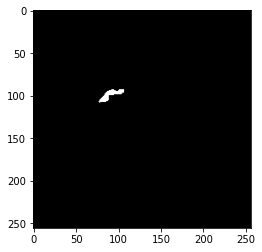

In [6]:
# Show individual image mask

plt.imshow(cv2.imread(brain_df.mask_path[623]))

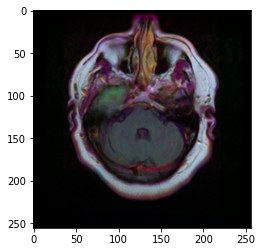

In [7]:
# Show individual image path

plt.imshow(cv2.imread(brain_df.image_path[623]))

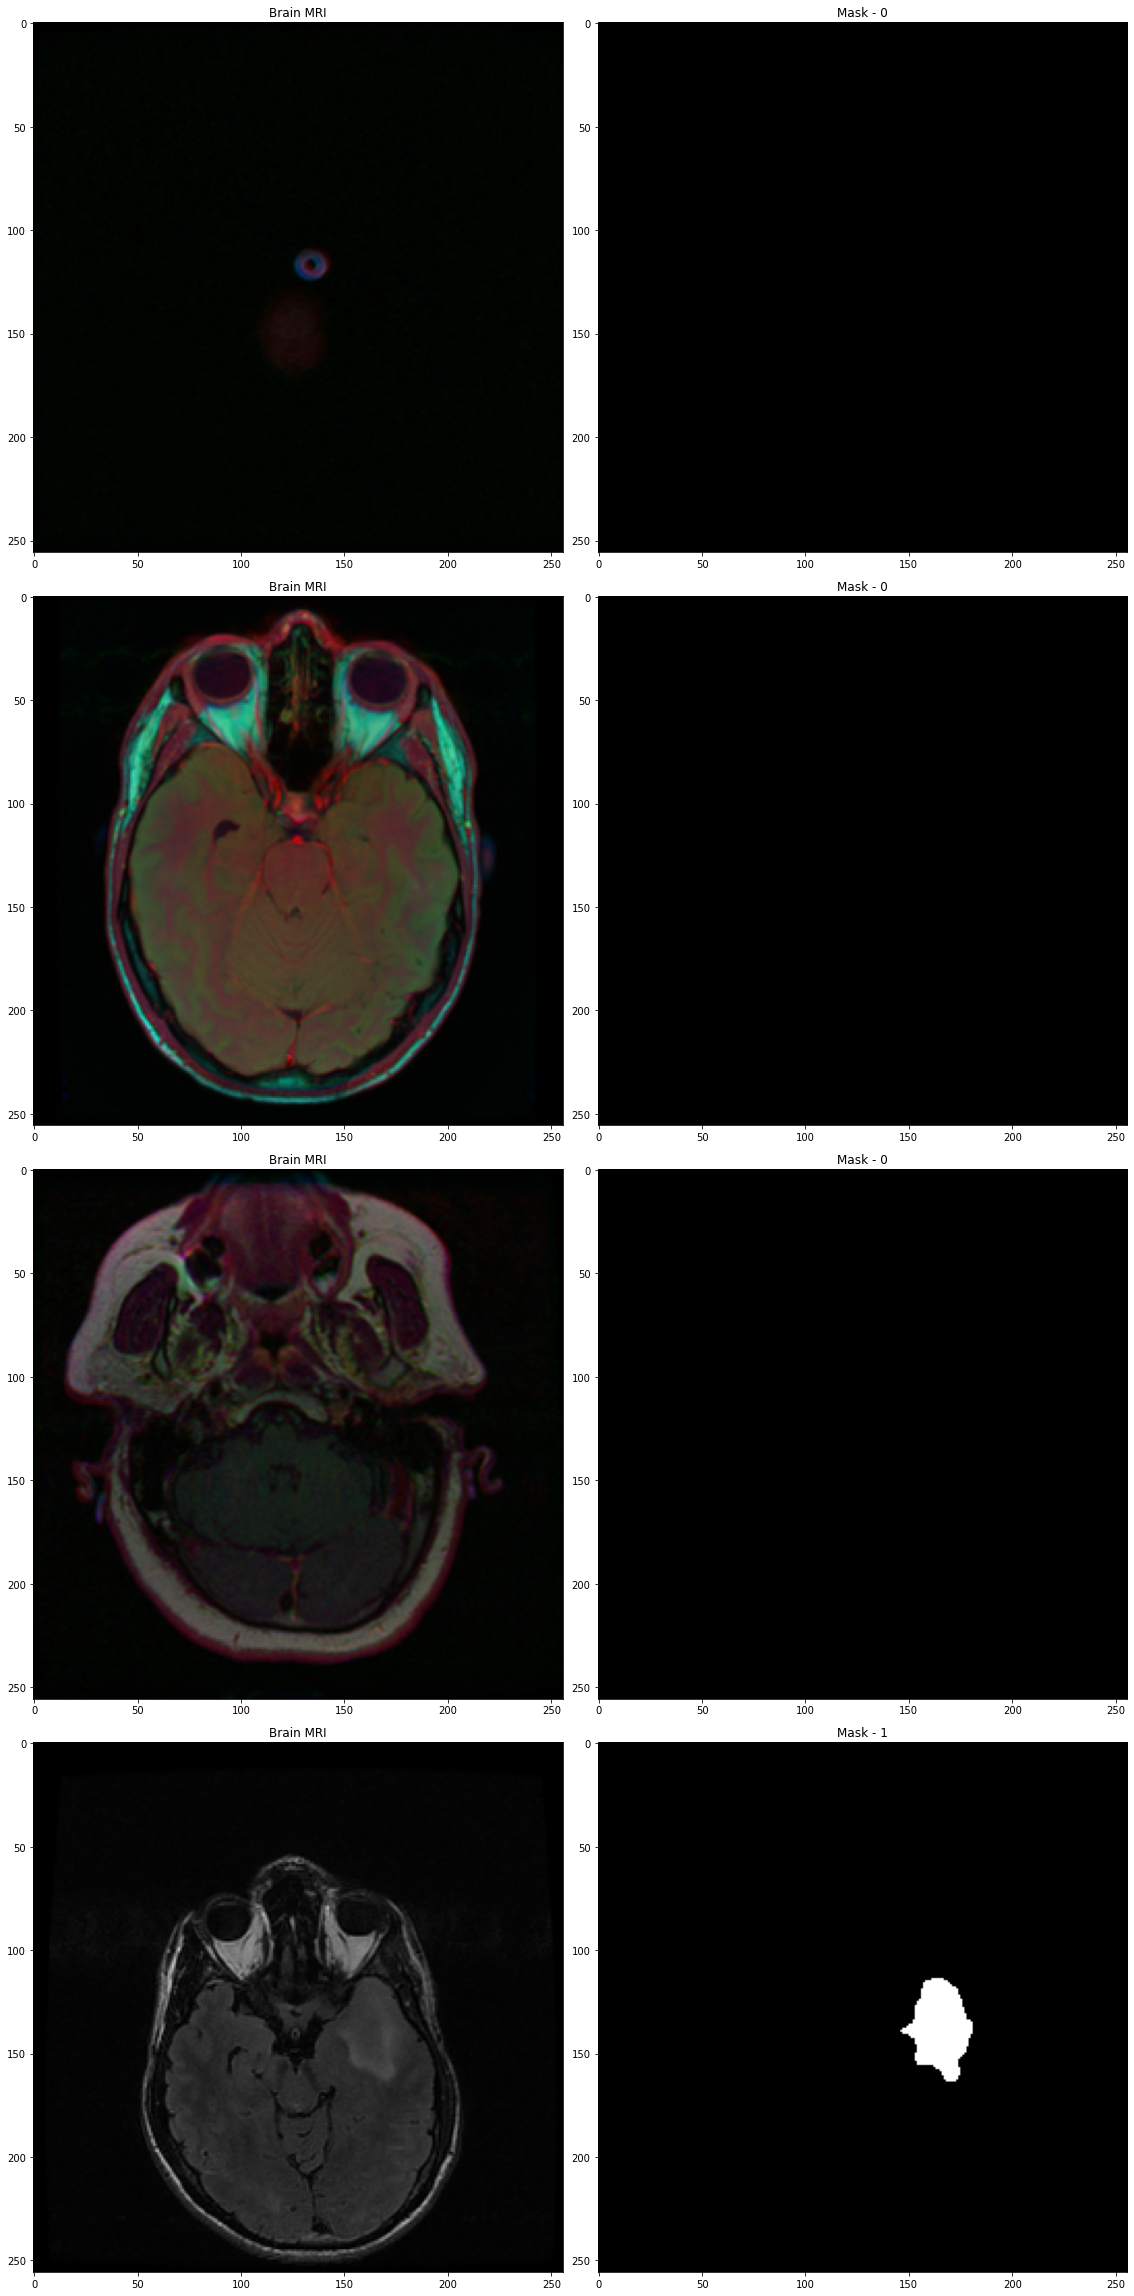

In [8]:
# (4) Randomly selected images from dataset to show MRI scan and corresponding mask 

import random
fig, axs = plt.subplots(4,2, figsize=(16,32))
count = 0
for x in range(4):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

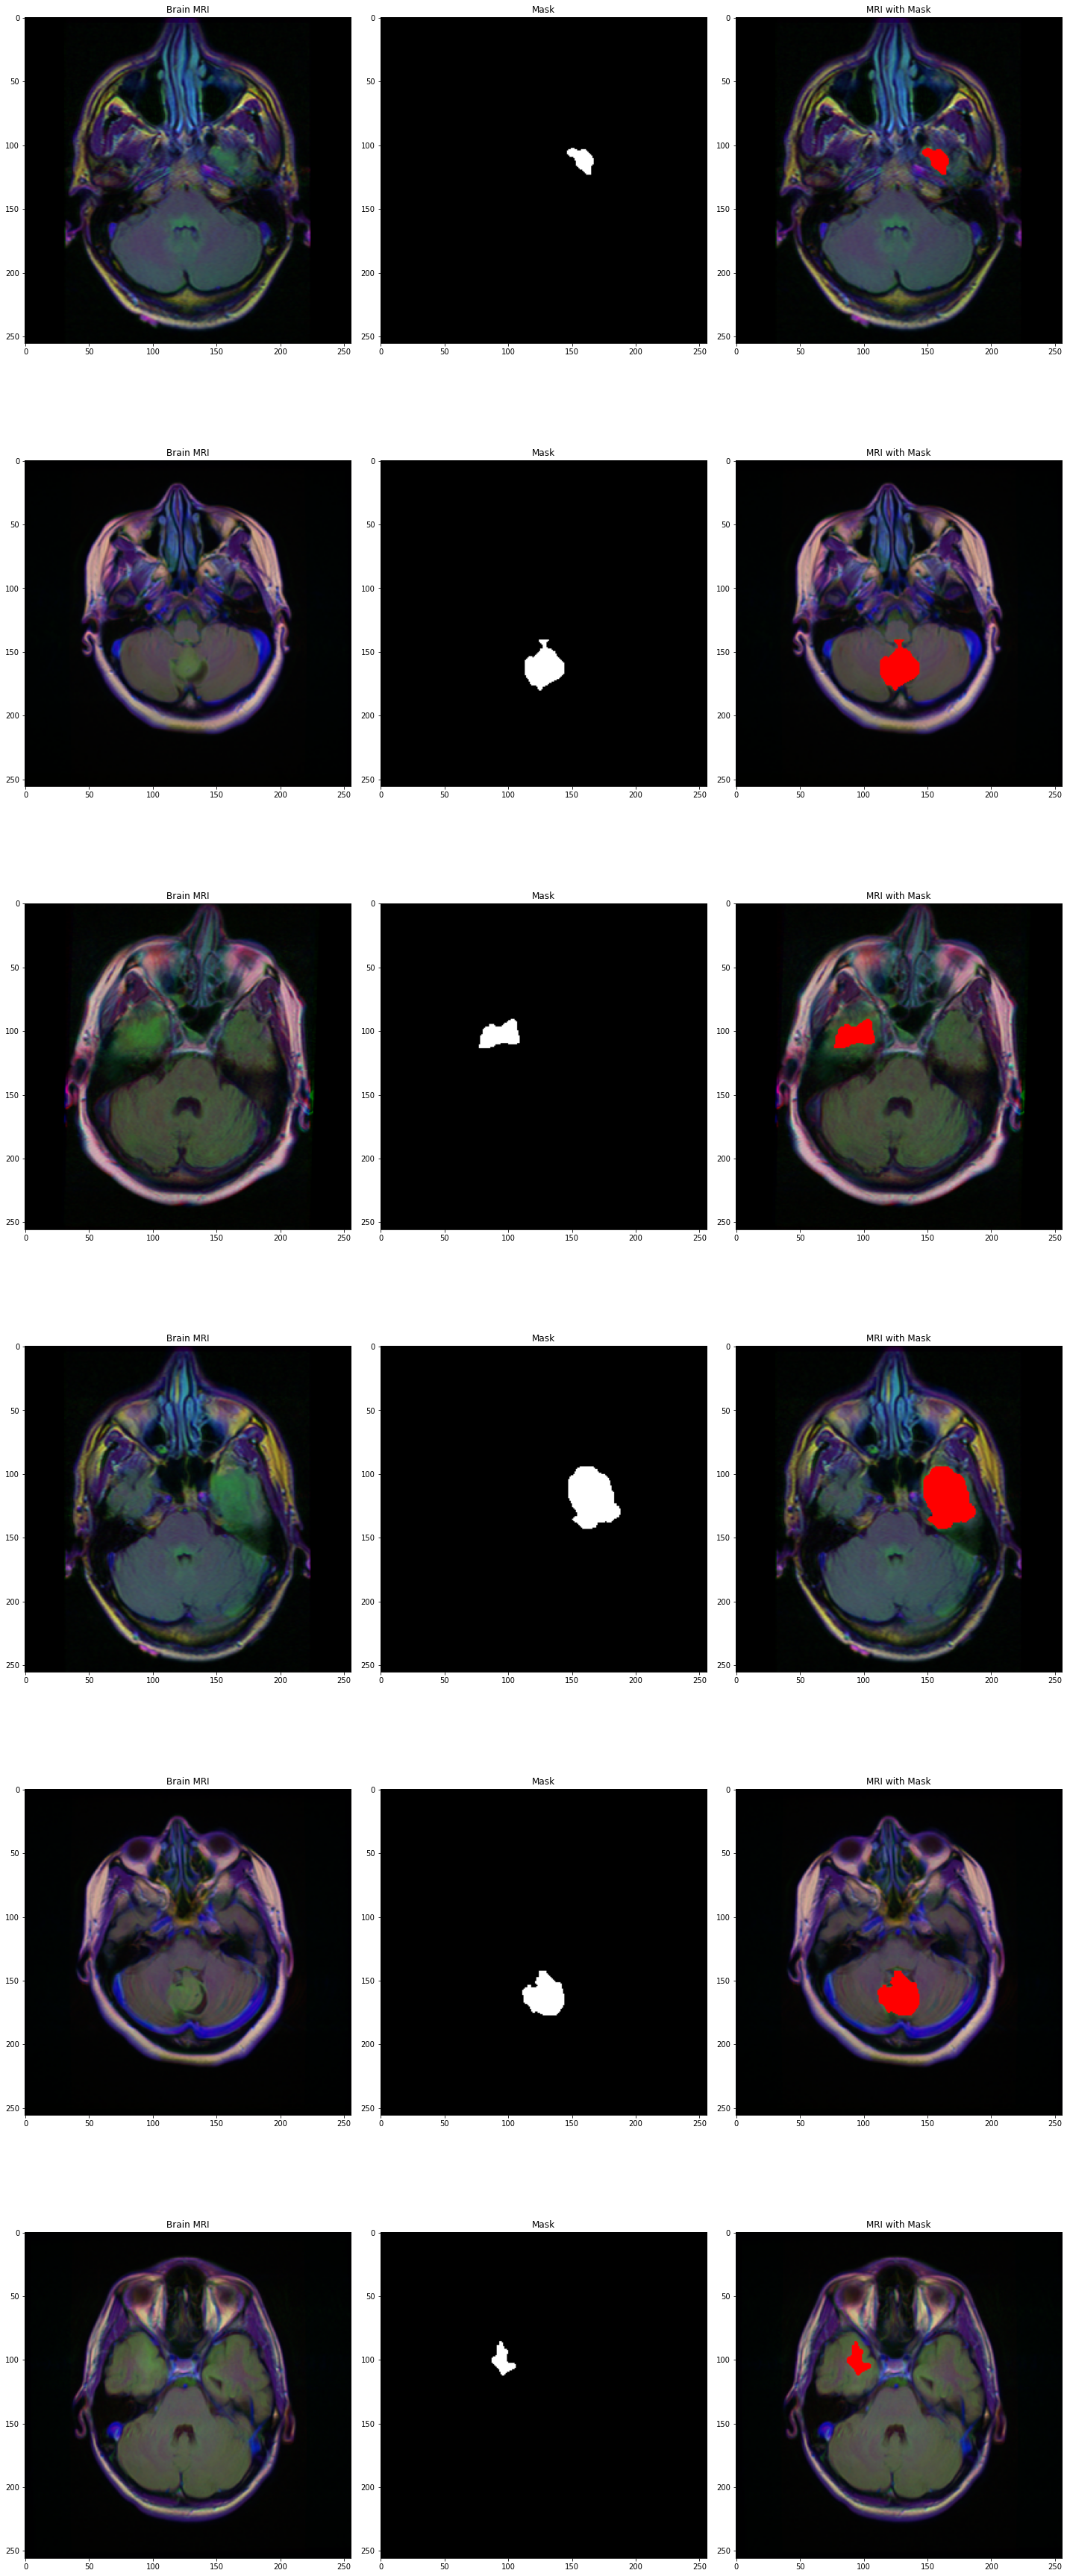

In [9]:
# (6) MRI & mask images with brain tumor presented and last column with MRI and mask in red

count = 0
fig, axs = plt.subplots(6, 3, figsize = (20, 50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] ==1 and count <6:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')
    
    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()

In [10]:
# Train a Classifier Model to detect if tumor exists or not

# Drop the patient id column

brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [11]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe

brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [12]:
# Split the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [13]:
# Create a image generator

from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

In [14]:
# Create a data generator for train images

train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for validation

valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [15]:
# Get the ResNet50 base model

basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

In [16]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [17]:
# Freeze the model weights for transfer of knowledge 

for layer in basemodel.layers:
  layers.trainable = False

In [20]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [21]:
# Compile the model

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [22]:
# Use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [23]:
# Training the model 

history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 1, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

177/177 [==============================] - ETA: 0s - loss: 0.8459 - accuracy: 0.7205
Epoch 00001: val_loss improved from inf to 0.65383, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 1761s 10s/step - loss: 0.8459 - accuracy: 0.7205 - val_loss: 0.6538 - val_accuracy: 0.6573


In [24]:
# Save the model architecture to json file for future use

model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

In [27]:
# Assess trained model performance 

# Load pretrained model 
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

    # load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [28]:
# Make prediction

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 66s 2s/step


In [29]:
# Obtain the predicted class from the model prediction

predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [30]:
# Test generator previously used, it limited the images to len(predict), due to batch size

original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [33]:
# Accuracy of the model

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9791666666666666

<AxesSubplot:>

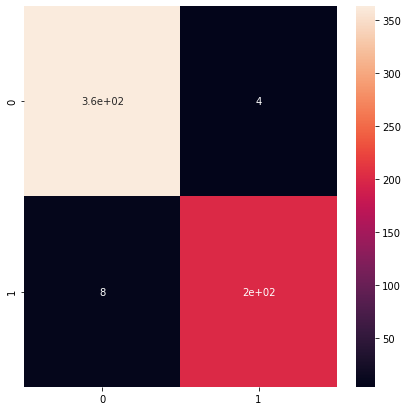

In [32]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [35]:
# Classification report and comment on the precision, recall and F1-score results

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       367
           1       0.98      0.96      0.97       209

   micro avg       0.98      0.98      0.98       576
   macro avg       0.98      0.98      0.98       576
weighted avg       0.98      0.98      0.98       576



In [58]:
# Build a Segmentation Model to locate tumor 

# Get the dataframe containing MRIs which have masks associated with them.

brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [59]:
# Split the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [60]:
# Create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [61]:
# Utilities file contains the code for custom loss function and custom data generator

from utilities import DataGenerator

# Create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [62]:
# Define resblock

def resblock(X, f):
  

  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [63]:
# Function to upscale and concatenate the values passsed

def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [64]:
# Build the model

input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

model_seg.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 256, 256, 16) 448         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_78 (BatchNo (None, 256, 256, 16) 64          conv2d_81[0][0]                  
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 256, 256, 16) 2320        batch_normalization_78[0][0]     
______________________________________________________________________________________

In [65]:
# Train a segmentation Resunet Model to localize tumor 

# Utilities file contains the code for custom loss function and custom data generator

from utilities import focal_tversky, tversky_loss, tversky

In [66]:
# Compile the model

adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [67]:
# Use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [72]:
# Training the model

# history = model_seg.fit(training_generator, epochs = 1, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

In [73]:
# Save the model architecture to json file for future use

'''
model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)
'''

'\nmodel_json = model_seg.to_json()\nwith open("ResUNet-model.json","w") as json_file:\n  json_file.write(model_json)\n'

In [76]:
# Assess trained segmentation Resunet Model performance 

from utilities import focal_tversky, tversky_loss, tversky

with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# Load the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [77]:
# Utilities file contains the code for custom loss function and custom data generator

from utilities import prediction

# Making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

In [78]:
# Creating a dataframe for the result

df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  \
0    TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_11...   
1    TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_36...   
2    TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_4.tif   
3    TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_17...   
4    TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_17...   
..                                                 ...   
585  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_73...   
586  TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_36...   
587  TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_46...   
588  TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_3.tif   
589  TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_3.tif   

                                        predicted_mask  has_mask  
0    [[[[8.085643e-07], [3.3977415e-06], [1.0653204...         1  
1                                              No mask         0  
2                                              No mask         0  
3                                              No mask         0  
4    [[[[7.800859e-07], [3.1395994e-06], [7.901658e...         1  
..                                                 ...       ...  
585                                            No mask         0  
586                                            No mask         0  
587  [[[[2.870349e-06], [3.314949e-06], [4.179365e-...         1  
588                                            No mask         0  
589                                            No mask         0  

[590 rows x 3 columns]

In [79]:
# Merge the dataframe containing predicted results with the original test data

df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  \
0  TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_11...   
1  TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_36...   
2  TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_4.tif   
3  TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_17...   
4  TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_17...   

                                           mask_path mask  \
0  TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_11...    1   
1  TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_36...    0   
2  TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_4_...    0   
3  TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_17...    0   
4  TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_17...    1   

                                      predicted_mask  has_mask  
0  [[[[8.085643e-07], [3.3977415e-06], [1.0653204...         1  
1                                            No mask         0  
2                                            No mask         0  
3                                            No mask         0  
4  [[[[7.800859e-07], [3.1395994e-06], [7.901658e...         1

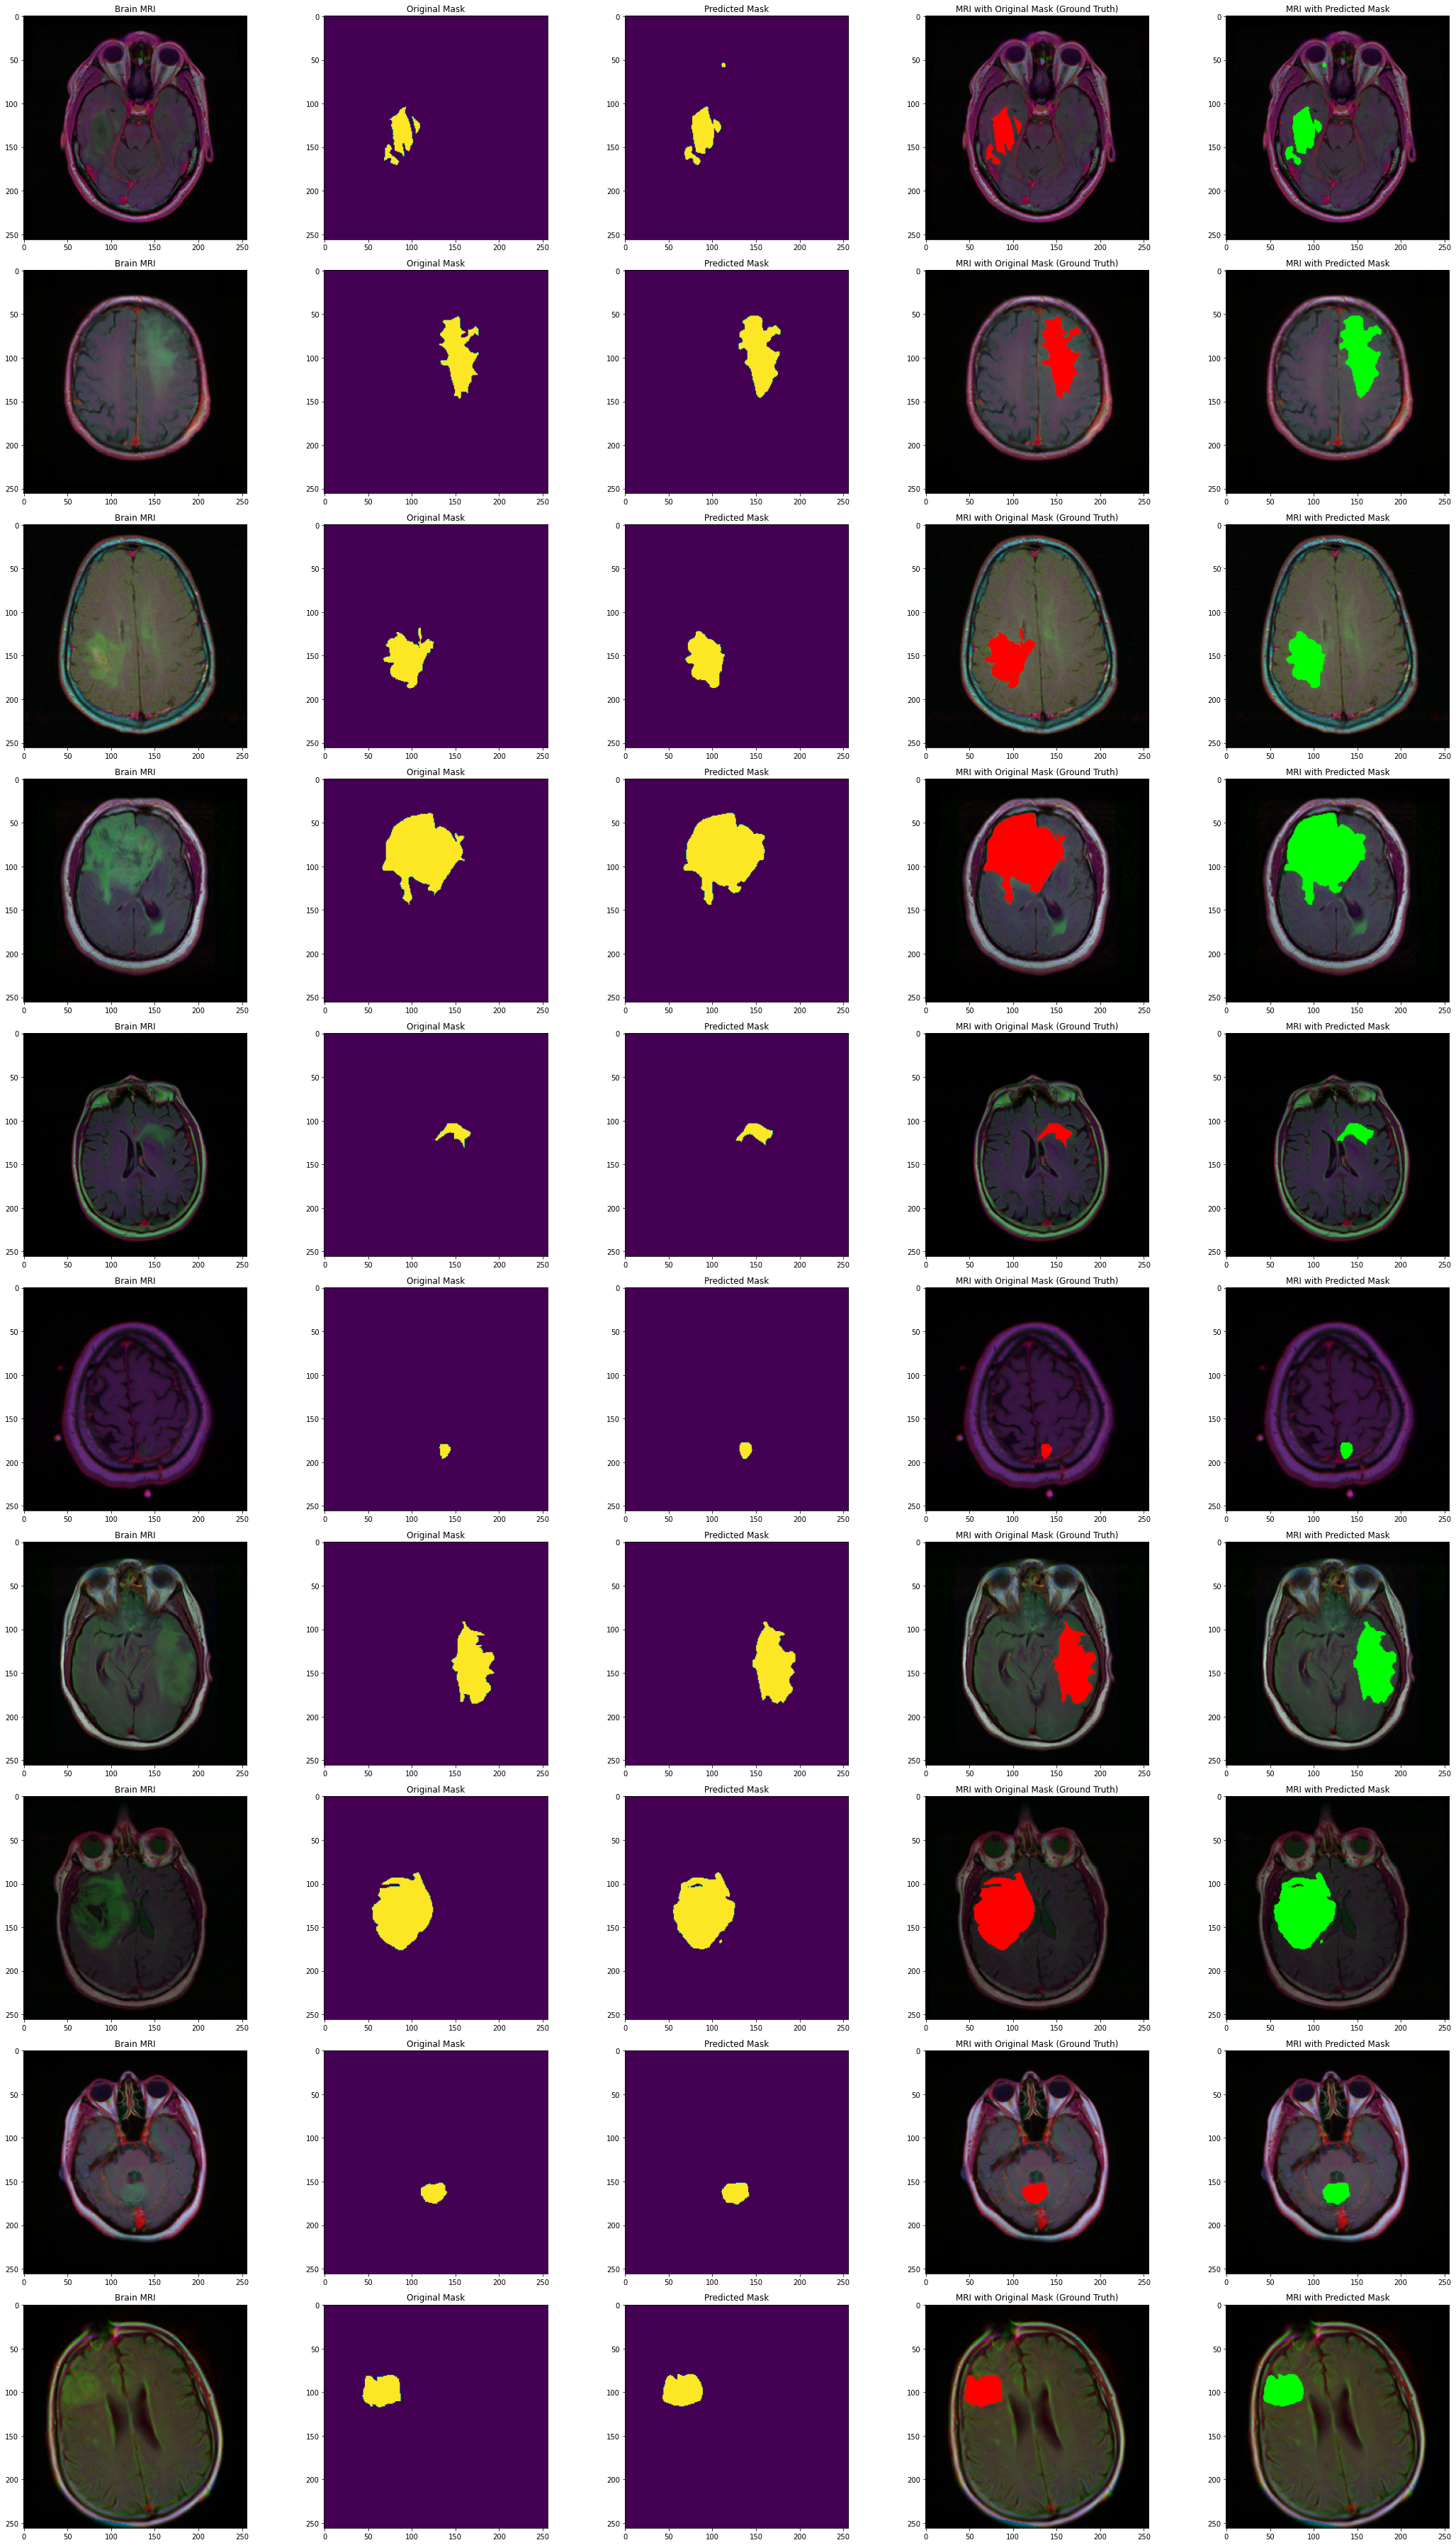

In [81]:
# (10) Brain MRI images with original & predicted mask images with brain tumor presented 

count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()